# Projekt SSN (Sztuczne sieci neuronowe)
### Autorzy: Aleksander Folfas, Zosia Jaworksa, Maciej Komosa, Kajetan Łodej, Natalia Łyś

### Opis
Lorem ipsum. <- tutaj ma być opis

### Przegląd literatury
Lorem ipsum. <- tutaj przeglad literatury

## Wstęp

In [53]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [54]:
# Wczytanie danych
housing = pd.read_csv("housing_price_dataset.csv")
housing.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


Zmienne w modelu:

- SquareFeet - powierzchnia w stopach kwadratowych
- Bedrooms - liczba sypialni
- Bathrooms - liczba łazienek
- Neighborhood - lokalizacja (miejska, podmiejska, wiejska)
- YearBuilt - rok budowy
- Price - cena

In [55]:
# Ziana Neighborhood na liczby
le = LabelEncoder()
housing["Neighborhood"] = le.fit_transform(housing["Neighborhood"])
housing.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,0,1969,215355.283618
1,2459,3,2,0,1980,195014.221626
2,1860,2,1,1,1970,306891.012076
3,2294,2,1,2,1996,206786.787153
4,2130,5,2,1,2001,272436.239065


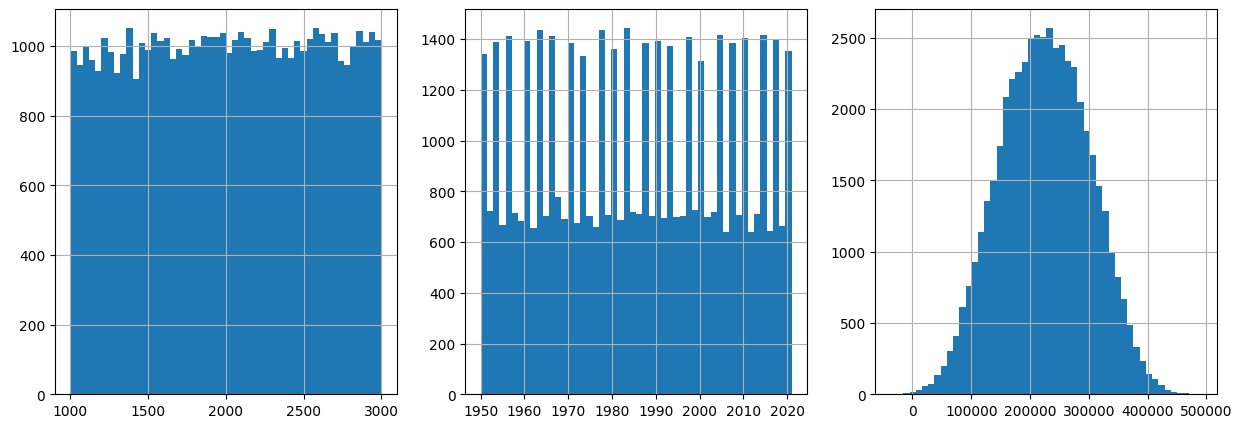

In [56]:
# Histogramy dla zmienny SquareFeet, YearBuilt, Price w grdzie 3x1
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
housing['SquareFeet'].hist(ax=axes[0], bins=50)
housing['YearBuilt'].hist(ax=axes[1], bins=50)
housing['Price'].hist(ax=axes[2], bins=50)
plt.show()

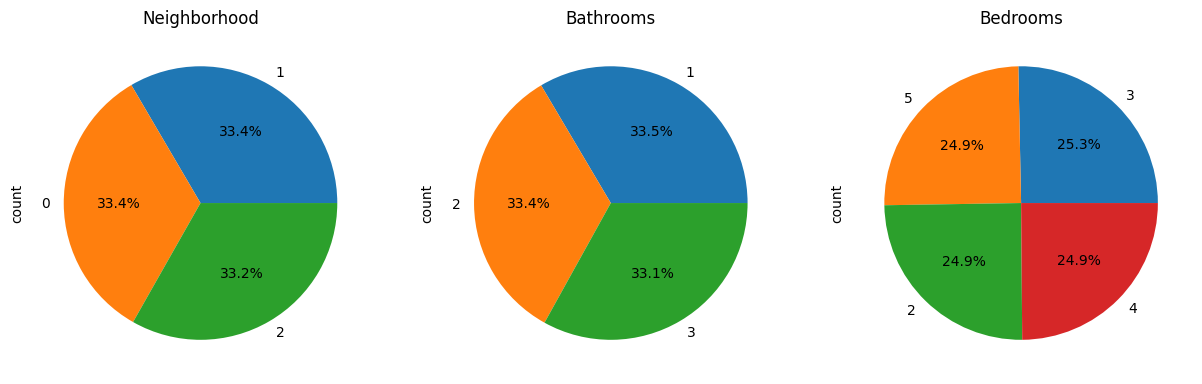

In [57]:
# Wykresy kołowe dla zmiennych: Neighborhood, Bathrooms, Bedrooms 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
housing['Neighborhood'].value_counts().plot(kind='pie', ax=axes[0], title = 'Neighborhood', autopct='%1.1f%%')
housing['Bathrooms'].value_counts().plot(kind='pie', ax=axes[1] , title = 'Bathrooms',  autopct='%1.1f%%')
housing['Bedrooms'].value_counts().plot(kind='pie', ax=axes[2], title = 'Bedrooms',  autopct='%1.1f%%')
plt.show()

Neighbourhood: 0 - Rural, 1 - Suburb, 2 - Urban

## Kod sztucznej sieci neuronowej

#### Warstwa, z metodami propagacji naprzód oraz wstecz

In [58]:
class warstwa:
    def __init__(self, liczba_wejsc, liczba_wyjsc, wspolczynnik_uczenia):
        self.x = None
        self.wagi = np.random.randn(liczba_wejsc, liczba_wyjsc) / np.sqrt(liczba_wejsc)
        rng = np.random.default_rng()
        self.bias = rng.random(liczba_wyjsc)
        self.liczba_wejsc = liczba_wejsc
        self.liczba_wyjsc = liczba_wyjsc
        self.wspolczynnik_uczenia = wspolczynnik_uczenia

    def naprzod(self, x, trening=False):
        if trening:
            self.x = x
        return np.dot(x, self.wagi) + self.bias
    
    def wstecz(self, dx):
        zmiana_wag = np.dot(self.x.T, dx)
        zmiana_biasu = np.sum(dx, axis=0)
        self.wagi = self.wagi - np.dot(self.wspolczynnik_uczenia, zmiana_wag)
        self.bias = self.bias - np.dot(self.wspolczynnik_uczenia, zmiana_biasu)
        return np.dot(dx, self.wagi.T)

#### Bramki aktywacji

In [59]:
class Sigmoid:
    def __init__(self):
        self.wyjscie = None

    def naprzod(self, x, trening=False):
        wynik = 1/(1+np.exp(-x))
        if trening:
            self.wyjscie = wynik
        return wynik
    
    def wstecz(self, dx):
        return dx * (1 - self.wyjscie) * self.wyjscie
    
class ReLU:
    def __init__(self):
        self.wyjscie = None

    def naprzod(self, x, trening=False):
        wynik = np.where(x > 0, x, 0)
        if trening:
            self.wyjscie = wynik
        return wynik
    
    def wstecz(self, dx):
        return dx * np.where(self.wyjscie > 0, 1, 0)
    
class Softplus:
    def __init__(self):
        self.wyjscie = None

    def naprzod(self, x, trening=False):
        wynik = np.log(1+np.exp(x))
        if trening:
            self.wyjscie = wynik
        return wynik
    
    def wstecz(self, dx):
        return dx * 1/(1+np.exp(-self.wyjscie))

### Neuron błędu

In [60]:
class MSE:
    def __init__(self):
        self.wyjscie = None
        self.x = None
        self.y = None

    def naprzod(self, x, y, trening=False):
        self.x = x
        self.y = y
        wynik = np.mean(np.power(x - y, 2))
        if trening:
            self.wyjscie = wynik
        return wynik
    
    def wstecz(self):
        return 2 * (self.x - self.y) / self.x.size

#### Perceptron, z metodami propagacji naprzód oraz wstecz
Przy propagacji naprzód przepuszcza dane wejściowe przez całą sieć, zwraca wyjście ostatniej warstwy (ostatnia warstwa jest jednym neuronem, wyjście jest jedną liczbą)
Przy propagacji wstecz oblicza błąd predykcji oraz przepuszcza go przez całą sieć, nie zwraca żadnej wartości

In [61]:
class wielowarstwowy_perceptron:
    def __init__(self, n_warstw, n_neuronow, n_wejsc, wspolczynnik_uczenia=0.01):
        self.warstwy = [warstwa(n_wejsc, n_neuronow, wspolczynnik_uczenia=0)]
        for _ in range(n_warstw):
            self.warstwy.append(warstwa(n_neuronow, n_neuronow, wspolczynnik_uczenia))
            self.warstwy.append(Sigmoid())
        self.warstwy.append(warstwa(n_neuronow, 1, wspolczynnik_uczenia))
        self.warstwa_bledu = MSE()

    def naprzod(self, x, trening):
        wejscie = x
        for warstwa in self.warstwy:
            wynik = warstwa.naprzod(wejscie, trening)
            wejscie = wynik
        return wynik

    def wstecz(self, wejscie):
        blad = wejscie
        for warstwa in reversed(self.warstwy):
            wynik = warstwa.wstecz(blad)
            blad = wynik
    
    def naprzod_oblicz_blad(self, x, y, trening):
        wynik = self.naprzod(x, trening)
        return self.warstwa_bledu.naprzod(wynik, y)

### Funkcje trenowania i testowania

In [62]:
def trenuj(model, X, y, n_okresow, wielkosc_serii=10):
    X_trening = X[::3] + X[1::3]
    X_walidacja = X[2::3]
    y_trening = y[::3] + y[::3]
    y_walidacja = y[2::3]

    for _ in tqdm(range(n_okresow)):
        indeksy_treningu = random.sample(range(len(X_trening)), wielkosc_serii)
        X_seria = np.array([X_trening[i] for i in indeksy_treningu])
        y_seria = np.array([y_trening[i] for i in indeksy_treningu])

        blad = model.naprzod_oblicz_blad(X_seria, y_seria, True)
        model.wstecz(blad)
    
    indeksu_walidacji = random.sample(range(len(X_walidacja)), wielkosc_serii)
    X_walidacja = np.array([X_walidacja[i] for i in indeksu_walidacji])
    y_walidacja = np.array([y_walidacja[i] for i in indeksu_walidacji])
    blad = model.naprzod_oblicz_blad(X_walidacja, y_walidacja, False)
    print("Blad: {}".format(blad))
    return X_walidacja, model.naprzod(X_walidacja, False)

### przygotowanie danych

In [63]:
from sklearn.preprocessing import MinMaxScaler
dane = pd.read_csv('housing_price_dataset.csv')

enkoder_etykiet = LabelEncoder()
for kolumna in dane.select_dtypes(include='object').columns:
    dane[kolumna] = enkoder_etykiet.fit_transform(dane[kolumna])

dane = dane.dropna().values

dane = MinMaxScaler((-1,1)).fit_transform(dane)
X = dane[:1011, :-1]
y = dane[:1011, -1]

# przebieg testowy

In [64]:
model = wielowarstwowy_perceptron(n_warstw=2, n_neuronow=5, n_wejsc=5)
zestaw_walidacyjny, wyjscie_modelu = trenuj(model, X, y, 20, 10)

100%|██████████| 20/20 [00:00<00:00, 5383.87it/s]

Blad: 0.15342336316194172
Wyjscie modelu: [[ 2.95370887e-04  1.18617702e-03 -1.34911726e-04  9.46408747e-04
   1.42352443e-03  1.47508886e-03  1.06302637e-03  6.25735261e-04
   2.79460707e-03  1.94543277e-03]
 [-2.44332397e-02 -2.35991357e-02 -2.48636636e-02 -2.38180588e-02
  -2.33445544e-02 -2.33282679e-02 -2.37251476e-02 -2.41245831e-02
  -2.20584988e-02 -2.28465923e-02]
 [-1.09287286e-01 -1.08612450e-01 -1.09693303e-01 -1.08765217e-01
  -1.08333610e-01 -1.08393988e-01 -1.08737115e-01 -1.09037338e-01
  -1.07288490e-01 -1.07913322e-01]
 [-1.52466208e-01 -1.51860562e-01 -1.52856063e-01 -1.51981874e-01
  -1.51576400e-01 -1.51666089e-01 -1.51983103e-01 -1.52241122e-01
  -1.50637671e-01 -1.51193029e-01]
 [-2.43334900e-02 -2.34942976e-02 -2.47449404e-02 -2.37077852e-02
  -2.32612184e-02 -2.32306131e-02 -2.36185205e-02 -2.40209586e-02
  -2.19818016e-02 -2.27761821e-02]
 [-1.37811170e-01 -1.37173837e-01 -1.38189390e-01 -1.37302685e-01
  -1.36911704e-01 -1.36974910e-01 -1.37294130e-01 -1.3757

### Kod funkcji aktywacji

In [65]:
# Logistyczna funkcja aktywacji
def sigmoid(x, pochodna = False):
    if pochodna:
        return sigmoid(x)*(1-sigmoid(x))
    return 
# Hiperboliczna funkcja aktywacji
def tanh(x, pochodna = False):
    if pochodna:
        return 1 - np.tanh(x)**2
    return np.tanh(x)
# Softplus
def softplus(x, pochodna = False):
    if pochodna:
        return sigmoid(x)
    return 
# Exponential Linear Unit - Elu
def elu(x, pochodna = False):
    if pochodna:
        return np.where(x > 0, 1, np.exp(x))
    return np.where(x > 0, x, np.exp(x) - 1)
# Rectified Linear Unit - ReLU
def relu(x, pochodna = False):
    if pochodna:
        return 
    return 
# Sigmoid linear unit - SiLU
def silu(x, pochodna = False):
    if pochodna:
        return sigmoid(x) + x*sigmoid(x)*(1-sigmoid(x))
    return x*sigmoid(x)
# Gaussian 
def gaussian(x, pochodna = False):
    if pochodna:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

### Wizualizacja funkcji aktywacji

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

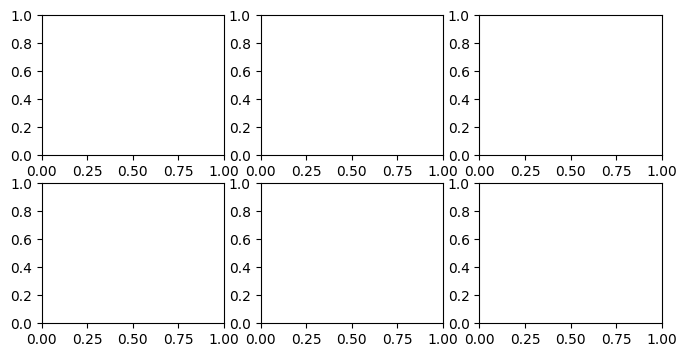

In [66]:
# Ustawienia siatki
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(8, 4))

# Tworzenie wykresów dla każdej funkcji
functions = [sigmoid, tanh, softplus, elu, silu, gaussian]
function_names = ['sigmoid', 'tanh', 'softplus', 'elu', 'silu', 'gaussian']

for i, ax in enumerate(axes.flatten()):
    x = np.linspace(-2, 2, 100)
    y = functions[i](x)
    y_derivatives = functions[i](x, pochodna=True)
    ax.axhline(0, color='black', linewidth=0.8)  
    ax.axvline(0, color='black', linewidth=0.8)
    ax.plot(x, y, linewidth=1.5)
    if y_derivatives is not None:
        ax.plot(x, y_derivatives, linewidth=1.5, linestyle='--')
    ax.set_title(function_names[i])
    ax.grid(True)

plt.tight_layout()

plt.show()
